Now combining the hovmoller plots for the two different sets of time periods into a single joint figure, following the previous template used in banded_and_local_changes.

In [17]:
from bootstrap import *
from chr_matplotlib import remappedColorMap
from jd_matplotlib_tools import add_double_calendar_axis, mark_time_periods
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import numpy.ma as ma
import os
from shutil import copy
import time

%load_ext autotime
%matplotlib inline

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 6.45 ms


In [2]:
ferretpath = "/Users/Siwen/Desktop/ferret/bin/"
ff = "Pchina_type_notaiwan.nc"
filename = ferretpath + ff
myf = nc.Dataset(filename, 'r')

time: 6.84 ms


In [3]:
P_total =  myf.variables['Pchina_total'][:]
P_band = myf.variables['Pchina_band'][:]
P_local = myf.variables['Pchina_local'][:]

time: 71.8 ms


In [4]:
#years of interest - start and end date, with index starting at 1 out of habit.
p1_yr_b = [1,30]
p1_yr_e = [29,43]
p2_yr_b = [30,44]
p2_yr_e = [57,57]

P_total_diff = []
P_band_diff = []
P_local_diff = []

#cycle through all time periods of interest and find changes in each type of rainfall b/w periods
for p1_b, p1_e, p2_b, p2_e, i in zip(p1_yr_b, p1_yr_e, p2_yr_b, p2_yr_e, np.arange(len(p1_yr_b))): 
    
    P_total_diff.append(np.mean(P_total[:,:,p2_b-1:p2_e], axis=2) - \
                         np.mean(P_total[:,:,p1_b-1:p1_e], axis=2))
    P_band_diff.append(np.mean(P_band[:,:,p2_b-1:p2_e], axis=2) \
                       - np.mean(P_band[:,:,p1_b-1:p1_e], axis=2))
    P_local_diff.append(np.mean(P_local[:,:,p2_b-1:p2_e], axis=2) \
                        - np.mean(P_local[:,:,p1_b-1:p1_e], axis=2))

time: 22 ms


In [5]:
def smooth(P,dayrange,latrange):
    Psmooth=np.zeros(P.shape)
    
    ll=int((dayrange-1)/2)
    yy=int((latrange-1)/2)
    
    days = P.shape[0]
    lats = P.shape[1]
    
    for d in range(days):
        for j in range(lats):
            
            Psample = P.take(range(d-ll,d+ll+1), mode='wrap', axis=0)
            Ps = Psample[:,max(0,j-yy):min(days,j+yy+1)]
            Psmooth[d,j] = np.mean(np.mean(Ps))
    
    return Psmooth

time: 6.75 ms


In [6]:
## SMOOTHING ##
#smooth out the decadal precipitation means
#but, no latitudinal smoothing since rainfall already effectively smoothed in latitude
daysmth = 15
latsmth = 0

#one line! thank you python!
P_total_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_total_diff ]
P_band_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_band_diff ]
P_local_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_local_diff ]

time: 4.07 s


In [7]:
## LOAD COMPUTED P-VALUES ##

#which set of sim values are we trying to access?
pval_root = 'Data/chinarain_diff_pval_notaiwan_'
blklen = 2
niter = 2000

P_total_diff_pval = []
P_band_diff_pval = []
P_local_diff_pval = []

#cycle through all time periods of interest and find changes in each type of rainfall b/w periods
for p1_b, p1_e, p2_b, p2_e, i in zip(p1_yr_b, p1_yr_e, p2_yr_b, p2_yr_e, np.arange(len(p1_yr_b))): 
    
    #LOAD P-VALUES FOR TOTAL RAINFALL
    raintype = 'total'
    yrs = str(p1_b+50) + str(p1_e+50) + '_' + str(p2_b+50) + str(p2_e+50) + '_'
    pval_filename = pval_root + yrs + raintype + '_' + str(blklen) + 'day_' \
        + str(niter) + 'iter.nc'
    
    if os.path.isfile(pval_filename):
        print(pval_filename + ' successfully found')
        myf = nc.Dataset(pval_filename, 'r')
        P_total_diff_pval.append(myf.variables['pval'][:])
        myf.close()
        
    else:
        print(pval_filename + ' does not exist')
    
    
    ##LOAD P-VALUES FOR BANDED RAINFALL
    raintype = 'band'
    yrs = str(p1_b+50) + str(p1_e+50) + '_' + str(p2_b+50) + str(p2_e+50) + '_'
    pval_filename = pval_root + yrs + raintype + '_' + str(blklen) + 'day_' \
        + str(niter) + 'iter.nc'
    
    if os.path.isfile(pval_filename):
        print(pval_filename + ' successfully found')
        myf = nc.Dataset(pval_filename, 'r')
        P_band_diff_pval.append(myf.variables['pval'][:])
        myf.close()
        
    else:
        print(pval_filename + ' does not exist')
            
    ##LOAD P-VALUES FOR LOCAL RAINFALL
    raintype = 'local'
    yrs = str(p1_b+50) + str(p1_e+50) + '_' + str(p2_b+50) + str(p2_e+50) + '_'
    pval_filename = pval_root + yrs + raintype + '_' + str(blklen) + 'day_' \
        + str(niter) + 'iter.nc'
    
    if os.path.isfile(pval_filename):
        print(pval_filename + ' successfully found')
        myf = nc.Dataset(pval_filename, 'r')
        P_local_diff_pval.append(myf.variables['pval'][:])
        myf.close()
        
    else:
        print(pval_filename + ' does not exist')    
        
    #P_total_diff.append()
    #P_band_diff.append(np.mean(P_band[:,:,p2_b-1:p2_e], axis=2) \
    #P_local_diff.append(np.mean(P_local[:,:,p2_b-1:p2_e], axis=2) \

Data/chinarain_diff_pval_notaiwan_5179_80107_total_2day_2000iter.nc successfully found
Data/chinarain_diff_pval_notaiwan_5179_80107_band_2day_2000iter.nc successfully found
Data/chinarain_diff_pval_notaiwan_5179_80107_local_2day_2000iter.nc successfully found
Data/chinarain_diff_pval_notaiwan_8093_94107_total_2day_2000iter.nc successfully found
Data/chinarain_diff_pval_notaiwan_8093_94107_band_2day_2000iter.nc successfully found
Data/chinarain_diff_pval_notaiwan_8093_94107_local_2day_2000iter.nc successfully found
time: 69.3 ms


In [8]:
## CREATE MASKED ARRAYS - only show values that are statistically significant
#create two masked arrays - one showing 95% confidence, one showing 99% confidence

##two separate for loops: first one creates masks, second one produces masked rainfall.
#reason for doing things this way is that masks can then be accessed independently at a later point in time.

#not super-pythonic method, but at least it makes it easy to understand.

mk_total = [] #storage format will be a LIST of 2-element tuples - each set of tuples is the 95% and 99% mask respectively
mk_band = []
mk_local = []

#set up 95th and 99th percentile masks for each type of rainfall
for P_total_diff, P_band_diff, P_local_diff, P_total_pval, P_band_pval, P_local_pval in \
    zip(P_total_diff_smth, P_band_diff_smth, P_local_diff_smth, P_total_diff_pval, P_band_diff_pval, P_local_diff_pval):
    
    mk_total_95 = abs(P_total_pval-.5) < .475 #95th percentile mask for rainfall changes
    mk_total_99 = abs(P_total_pval-.5) < .495 #99th percentile mask for rainfall changes
    mk_total.append([mk_total_95, mk_total_99])
    
    mk_band_95 = abs(P_band_pval-.5) < .475 #95th percentile mask for rainfall changes
    mk_band_99 = abs(P_band_pval-.5) < .495 #99th percentile mask for rainfall changes
    mk_band.append([mk_band_95, mk_band_99])
    
    mk_local_95 = abs(P_local_pval-.5) < .475 #95th percentile mask for rainfall changes
    mk_local_99 = abs(P_local_pval-.5) < .495 #99th percentile mask for rainfall changes
    mk_local.append([mk_local_95, mk_local_99])
    
#create masked arrays
P_total_diff_mask = []
P_band_diff_mask = []
P_local_diff_mask = []

#create masked arrays with significant rainfall changes only based on 95th percentile masks
for P_total_diff, P_band_diff, P_local_diff, mask_total, mask_band, mask_local in \
    zip(P_total_diff_smth, P_band_diff_smth, P_local_diff_smth, mk_total, mk_band, mk_local):
    
    P_total_diff_mask.append(ma.array(P_total_diff, mask = mask_total[0]))
    P_band_diff_mask.append(ma.array(P_band_diff, mask = mask_band[0]))
    P_local_diff_mask.append(ma.array(P_local_diff, mask = mask_local[0]))

time: 16.7 ms


In [9]:
## LOAD 1980-2007 v 1951-1979 changes FROM NETCF ##

## NETCDF FILENAMES
freq_diff_file = "RDA_freq_diff_tau_seasonal"
freq_diff_name = ferretpath + freq_diff_file + '.nc'

int_diff_file = "RDA_int_diff"
int_diff_name = ferretpath + int_diff_file + '.nc'

int_pval_file = "RDA_int_diff_bootstrap_2000iter_perm"
int_pval_name = ferretpath + int_pval_file + '.nc'



#import from netCDF file and load 57-year climatology
freq_diff_netcdf = nc.Dataset(freq_diff_name, "r")
int_diff_netcdf = nc.Dataset(int_diff_name, "r")
int_pval_netcdf = nc.Dataset(int_pval_name, "r")

#limits of different time periods that we're comparing
p1_beg = [1951,1980]
p1_end = [1979,1993]
p2_beg = [1980,1994]
p2_end = [2007,2007]

#in this case, we're just going to load the smoothed plots of hovmoller frequency
freq_diff = []
freq_pval = []
int_diff = []
int_pval = []

for p1_b, p1_e, p2_b, p2_e in zip(p1_beg, p1_end, p2_beg, p2_end):

    years_p1= str(p1_b-1900) + str("{0:0=2d}".format((p1_e-1900)%100))
    print(years_p1)
    years_p2= str(p2_b-1900) + str("{0:0=2d}".format((p2_e-1900)%100))
    print(years_p2)
    
    freq_diff.append(freq_diff_netcdf['lat_diff_tau_' + years_p2 + '_' + years_p1][:])
    freq_pval.append(freq_diff_netcdf['lat_pval_tau_' + years_p2 + '_' + years_p1][:])
    int_diff.append(int_diff_netcdf['int_diff_' + years_p2 + '_' + years_p1][:])
    int_pval.append(int_pval_netcdf['int_pval_' + years_p2 + '_' + years_p1][:])
    
#close it
freq_diff_netcdf.close()
int_diff_netcdf.close()
int_pval_netcdf.close()


5179
8007
8093
9407
time: 59.4 ms


In [10]:
## USE P-VALS TO CREATE MASKS APPLIED TO ONLY SHOW SIGNIFICANT DIFFERENCES
## 1980-2007 versus 1951-1979 - clearly cuts out a lot of random noise!

## frequency masking by analytic p-value
freq_diff_mask_95 = []
freq_diff_mask_99 = []

for fq, pval in zip(freq_diff, freq_pval):
    freq_diff_mask_95.append(ma.array(fq, mask = ~(abs(pval-.5) > .475)))
    freq_diff_mask_99.append(ma.array(fq, mask = ~(abs(pval-.5) > .495)))

#intensity masking by bootstrapped p-value
int_diff_mask_95 = []
int_diff_mask_99 = []   
    
for ints, pval in zip(int_diff, int_pval):
    int_diff_mask_95.append(ma.array(ints, mask = ~(abs(pval-.5) > .475)))
    int_diff_mask_99.append(ma.array(ints, mask = ~(abs(pval-.5) > .495)))

time: 9.8 ms


In [11]:
## DEFINE TIME PERIODS OF INTEREST
time_periods = [[80.5,120.5],[120.5,160.5],[160.5,200.5],[200.5,273.5],[273.5,320.5]]

time: 684 µs


In retrospect, the way that I did the rest of this code is not up to par, but hindsight is 20/20

In [13]:
## Set up variables that will be plotted in correct order
P_plot_tuples = {'a':[P_total_diff_mask[0].T,P_band_diff_mask[0].T,100*freq_diff_mask_95[0][:,1:21].T,\
                   int_diff_mask_95[0][:,1:21].T],
                 'b':[P_total_diff_mask[1].T,P_band_diff_mask[1].T,100*freq_diff_mask_95[0][:,1:21].T,\
                   int_diff_mask_95[0][:,1:21].T]}

P_contour_tuples = {'a':[mk_total[0][1].T,mk_band[0][1].T,freq_diff_mask_99[0][:,1:21].mask.T,\
                         int_diff_mask_99[0][:,1:21].mask.T],
                    'b':[mk_total[1][1].T,mk_band[1][1].T,freq_diff_mask_99[1][:,1:21].mask.T,\
                         int_diff_mask_99[1][:,1:21].mask.T]}

time: 7.06 ms


[0, 0]
[1, 0]
[2, 0]
[3, 0]
[0, 0]
[1, 0]
[2, 0]
[3, 0]


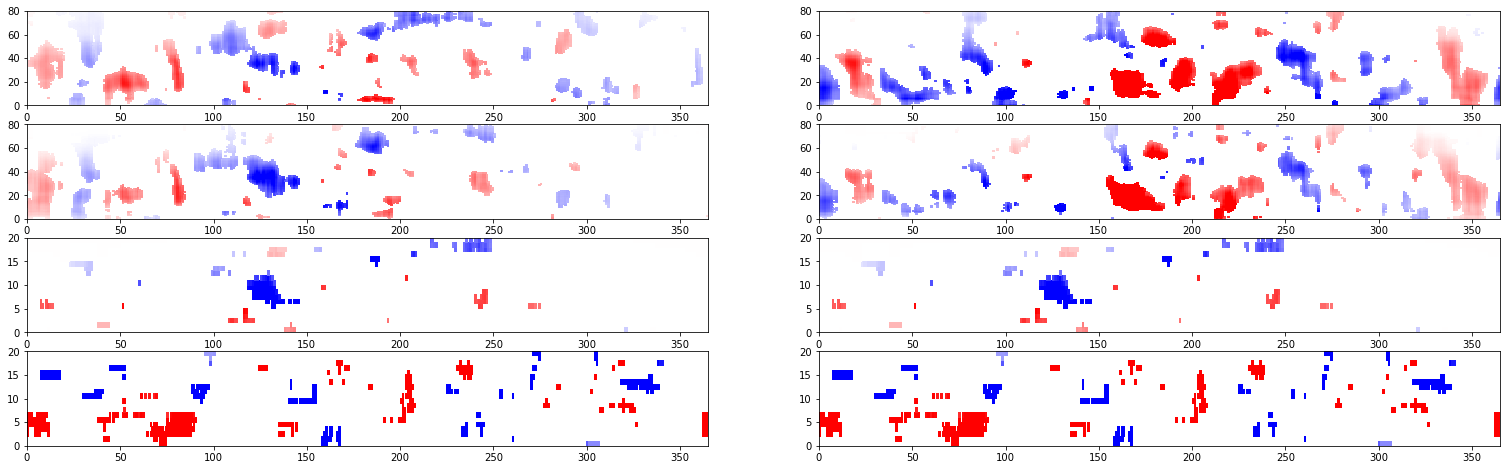

time: 1.1 s


In [25]:
## New version of Hovmoller plots of difference, based off of banded_and_local_changes
axlim = 2
mypalette = 'bwr'

fig = plt.figure(figsize=(22,8), facecolor='w')
#st = plt.suptitle("Changes in Rainfall by Type", size = 32, y=1, x=.515)

## create grids for left-hand and right-hand sides
grid_left = gridspec.GridSpec(4, 1)
grid_left.update(left=0.05, right=0.48)
grid_right = gridspec.GridSpec(4, 1)
grid_right.update(left=0.55, right=0.98)
grids = {'a':grid_left, 'b':grid_right}

## create storage dict for axes objects for each side; a is left, b is right
axes = {'a':[], 'b':[]}

## Define title for each subplot
subplot_titles=["a) Change in Total Rainfall (mm day$^{-1}$)","b) Change in Banded Rainfall (mm day$^{-1}$)",\
                "c) Change in Band Frequency (%)","d) Change in Band Intensity (mm day$^{-1}$)"]

## Define title for each half of the figure
panel_titles = {'a':'1980-2007 v 1951-1979','b':'1994-2007 v 1980-1993'}

## Biggest change from previous version is that instead of explicitly
## enumerating each subplot, now line everything up at the beginning and
## then iterate through each subplot with an identical loop
for half in ['a','b']:
    for row,(precip,contour,title) in enumerate(zip(P_plot_tuples[half],P_contour_tuples[half],\
                                                  subplot_titles)):
        print([row,0])
        print(grids[half][row,0])
        ax = plt.subplot(grids[half][row,0])
        axes[half].append(ax)
        ax.pcolormesh(precip, cmap = mypalette, vmin = -axlim, vmax = axlim); 
        ax.contour(contour,1,colors = 'gray')
        #dc = decadal_change(precip,season,years[half][0],years[half][1])
        #im = plt.imshow(dc, origin = 'lower', vmax=100, vmin=-100, cmap = 'bwr')
        #ax.set_title(title, fontsize=24, y = 1.05)
        #ax.set_ylabel('Latitude ($\!^\circ\!$)', fontsize=22, labelpad=0, rotation='horizontal',\
        #              horizontalalignment='right',verticalalignment='center')
        #ax.set_xticks(xtickpos)
        #ax.set_xticklabels(xticklabels)
        #ax.set_yticks(ytickpos)
        #ax.set_yticklabels(yticklabels)
        #ax.tick_params(axis='y', which='major', pad=2)
        
    ## add title to this half - place right above middle panel in top row
    #pos = axes[half][1].get_position() # get the original position 
    #xx = (pos.x0+pos.x1)/2
    #yy = pos.y1+.05
    #lt.figtext(xx,yy,panel_titles[half],horizontalalignment='center',size=24)

/Users/Siwen/anaconda/lib/python3.6/site-packages/matplotlib/text.py:2138: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


Overwriting existing version of file in RDA manuscript directory...
Overwriting existing version of file in RDA Python directory...


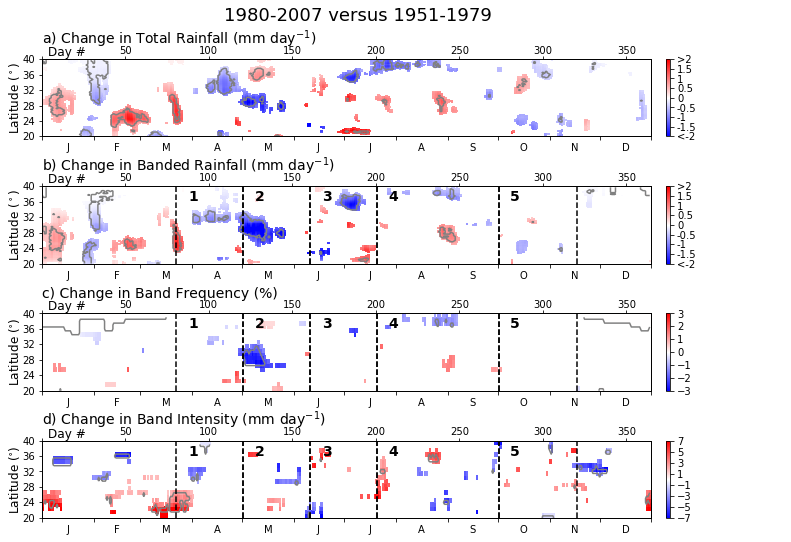

time: 31.1 s


In [12]:
## CREATE FIGURE OF 1951-1979 v 1980-2007 changes

axlim = 2 #sets the maximum and minimum for colorbar.
mypalette = 'bwr'

## Set up axis and title for the entire figure
fig, ax = plt.subplots(figsize=(11,8))
ax.set_title("1980-2007 versus 1951-1979", fontsize=18, y = 1.07, x=.43)
ax.set_axis_off()

## Subplot a) - changes in TOTAL rainfall
ax1 = fig.add_subplot(4,1,1)
plot1 = ax1.pcolormesh(P_total_diff_mask[0].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_total[0][1].T,1,colors = 'gray')
ax1.set_title("a) Change in Total Rainfall (mm day$^{-1}$)", fontsize=14, y=1.12, loc = 'left')
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

cbar1 = plt.colorbar(plot1, pad = 0.02)
cbar1.set_ticks(np.linspace(-axlim,axlim,9))
cbar1.set_ticklabels(['<-2',-1.5,-1,-.5,0,.5,1,1.5,'>2'])

add_double_calendar_axis()
#mark_time_periods(time_periods, numbers = 'yes', box = 'no')


## Subplot b) - changes in BANDED rainfall
ax2 = fig.add_subplot(4,1,2)
plot2 = ax2.pcolormesh(P_band_diff_mask[0].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_band[0][1].T,1,colors = 'gray')
ax2.set_title("b) Change in Banded Rainfall (mm day$^{-1}$)", fontsize=14, y=1.12, loc = 'left')
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

cbar2 = plt.colorbar(plot2, pad = 0.02)
cbar2.set_ticks(np.linspace(-axlim,axlim,9))
cbar2.set_ticklabels(['<-2',-1.5,-1,-.5,0,.5,1,1.5,'>2'])

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes', box = 'no')


## Subplot c) FREQUENCY CHANGES
ax3 = fig.add_subplot(4,1,3)
plot3 = ax3.pcolormesh(100*freq_diff_mask_95[0][:,1:21].T, cmap = mypalette, vmin = -3, vmax = 3); 
plt.contour(freq_diff_mask_99[0][:,1:21].mask.T,1,colors = 'gray')
plt.ylabel('Latitude ($\!^\circ\!$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,20,6),np.linspace(20,40,6).astype(int))

cbar3 = plt.colorbar(plot3, pad=0.02)
cbar3.set_ticks(np.linspace(-3,3,7))

ax3.set_title("c) Change in Band Frequency (%)", fontsize=14, y=1.12, loc = 'left')
add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes', box = 'no')


## Subplot d) INTENSITY CHANGES
ax4 = fig.add_subplot(4,1,4)
plot4 = ax4.pcolormesh(int_diff_mask_95[0][:,1:21].T, cmap = mypalette, vmin = -7, vmax = 7); 
plt.contour(int_diff_mask_99[0][:,1:21].mask.T,1,colors = 'gray')
ax4.set_title("d) Change in Band Intensity (mm day$^{-1}$)", fontsize=14, y=1.12, loc = 'left')
plt.ylabel('Latitude ($\!^\circ\!$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,20,6),np.linspace(20,40,6).astype(int))

cbar4 = plt.colorbar(plot4, pad=0.02)
cbar4.set_ticks(np.linspace(-7,7,8))

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes', box = 'no')


## Final tweak to adjust plot fit.
plt.tight_layout(pad=0, w_pad=0, h_pad=0)


## CREATE FIGURE OF 1994-2007 versus 1980-1993 changes

## CREATE FIGURE OF 1980-1993 v 1994-2007 changes

axlim = 4 #sets the maximum and minimum for colorbar.

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title("1994-2007 versus 1980-1993", fontsize=18, y = 1.07, x=.43)
mypalette = 'bwr'

ax.set_axis_off()


## Subplot a) - changes in TOTAL rainfall
ax1 = fig.add_subplot(4,1,1)
plot1 = ax1.pcolormesh(P_total_diff_mask[1].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_total[1][1].T,1,colors = 'gray')
ax1.set_title("a) Change in Total Rainfall (mm day$^{-1}$)", fontsize=14, y=1.12, loc = 'left')
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

cbar1 = plt.colorbar(plot1, pad = 0.02)
cbar1.set_ticks(np.linspace(-axlim,axlim,9))
cbar1.set_ticklabels(['<-2',-1.5,-1,-.5,0,.5,1,1.5,'>2'])

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes', box = 'no')


## Subplot b) - changes in BANDED rainfall
ax2 = fig.add_subplot(4,1,2)
plot2 = ax2.pcolormesh(P_band_diff_mask[1].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_band[1][1].T,1,colors = 'gray')
ax2.set_title("b) Change in Banded Rainfall (mm day$^{-1}$)", fontsize=14, y=1.12, loc = 'left')
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

cbar2 = plt.colorbar(plot2, pad = 0.02)
cbar2.set_ticks(np.linspace(-axlim,axlim,9))
cbar2.set_ticklabels(['<-2',-1.5,-1,-.5,0,.5,1,1.5,'>2'])

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes', box = 'no')


## c) Frequency changes
ax3 = fig.add_subplot(4,1,3)
plot3 = ax3.pcolormesh(100*freq_diff_mask_95[1][:,1:21].T, cmap = mypalette, vmin = -3, vmax = 3); 
plt.contour(freq_diff_mask_99[1][:,1:21].mask.T,1,colors = 'gray')
ax3.set_title("c) Change in Band Frequency (%)", fontsize=14, y=1.12, loc = 'left')
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,20,6),np.linspace(20,40,6).astype(int))

cbar3 = plt.colorbar(plot3, pad=0.02)
cbar3.set_ticks(np.linspace(-3,3,7))

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes', box = 'no')



## d) Intensity changes
ax4 = fig.add_subplot(4,1,4)
plot4 = ax4.pcolormesh(int_diff_mask_95[1][:,1:21].T, cmap = mypalette, vmin = -7, vmax = 7); 
plt.contour(int_diff_mask_99[1][:,1:21].mask.T,1,colors = 'gray')
ax4.set_title("d) Change in Band Intensity (mm day$^{-1}$)", fontsize=14, y=1.12, loc = 'left')
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,20,6),np.linspace(20,40,6).astype(int))

cbar4 = plt.colorbar(plot4, pad=0.02)
cbar4.set_ticks(np.linspace(-7,7,8))

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes', box = 'no')



## we have separate axis for whole figure and for each subplot
plt.tight_layout(pad=0, w_pad=0, h_pad=0)


## SAVE COPIES OF FIGURE TO MANUSCRIPT AND ANALYSIS DIRECTORIES
figure_name = "hov_summary_9407_8093.pdf"

savepath = "/Users/Siwen/Desktop/RDA/Figures/" + figure_name

if os.path.exists(savepath):
    print("Overwriting existing version of file in RDA manuscript directory...")
    os.remove(savepath)
    
plt.savefig(savepath)
    
copypath = "/Users/Siwen/RDA/Figures/" + figure_name
    
if os.path.exists(copypath):
    print("Overwriting existing version of file in RDA Python directory...")
    os.remove(copypath)
    
copy(savepath,copypath)

plt.savefig(savepath, bbox_inches='tight')



## SAVE FIGURE TO MANUSCRIPT AND ANALYSIS DIRECTORIES
figure_name = "hov_summary_8007_5179.pdf"
savepath = "/Users/Siwen/Desktop/RDA/Figures/" + figure_name

if os.path.exists(savepath):
    print("Overwriting existing version of file in RDA manuscript directory...")
    os.remove(savepath)
    
plt.savefig(savepath)
    
copypath = "/Users/Siwen/RDA/Figures/" + figure_name
    
if os.path.exists(copypath):
    print("Overwriting existing version of file in RDA Python directory...")
    os.remove(copypath)
    
copy(savepath,copypath)

plt.savefig(savepath, bbox_inches='tight')

In [ ]:


## SAVE COPIES OF FIGURE TO MANUSCRIPT AND ANALYSIS DIRECTORIES
figure_name = "hov_summary_9407_8093.pdf"

savepath = "/Users/Siwen/Desktop/RDA/Figures/" + figure_name

if os.path.exists(savepath):
    print("Overwriting existing version of file in RDA manuscript directory...")
    os.remove(savepath)
    
plt.savefig(savepath)
    
copypath = "/Users/Siwen/RDA/Figures/" + figure_name
    
if os.path.exists(copypath):
    print("Overwriting existing version of file in RDA Python directory...")
    os.remove(copypath)
    
copy(savepath,copypath)

plt.savefig(savepath, bbox_inches='tight')



## SAVE FIGURE TO MANUSCRIPT AND ANALYSIS DIRECTORIES
figure_name = "hov_summary_8007_5179.pdf"
savepath = "/Users/Siwen/Desktop/RDA/Figures/" + figure_name

if os.path.exists(savepath):
    print("Overwriting existing version of file in RDA manuscript directory...")
    os.remove(savepath)
    
plt.savefig(savepath)
    
copypath = "/Users/Siwen/RDA/Figures/" + figure_name
    
if os.path.exists(copypath):
    print("Overwriting existing version of file in RDA Python directory...")
    os.remove(copypath)
    
copy(savepath,copypath)

plt.savefig(savepath, bbox_inches='tight')